<a href="https://colab.research.google.com/github/Willyzw/monodepth2/blob/master/monodepth2_handson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Tracking the pose of a moving camera and simultanously inferring the **dense** 3D structure of the environment is a long-standing problem which is often denoted as **DenseSLAM**. Traditionally it is approached by two steps, namely a sparse set of feature points along with camera poses is firstly estimated, then followed by multi-view stereo(MVS) to construct the dense scene structure. While this traditional toolchain is well studied consisting of multiple elaborate hand-crafted stages, it lacks robustness in cases such as low texture, thin structure and dynamic objects. Besides that, modern applications like augmented reality or automated driving demand real-time dense scene perceiving for operations like interaction between physical and virtual objects and obstacle avoidance.

With the rapid development and recent advances of deep learning, there has been remarkable progress in this field in recent years. **MonoDepth2**[1] is one of the most representative works. It consists of a depth and a pose network to estimate depth map and camera pose respectively. More specifically, the pose network takes a pair of consecutive images $I_{t-1}$ and $I_t$ and outputs the relative transform from $I_{t-1}$ to $I_t$, while the depth network can map a RGB image $I_{t}$ though an encoder-decoder network to its corresponding depth map. This process can be illustrated as the figure below (Figure 1 of SfMLearner [3])  
![](https://github.com/Willyzw/monodepth2/raw/master/assets/sfmlearner.png)

This notebook aims to convey the MonoDepth2's principles by showing an example. Firstly the required development environment will be set up. Then, a few example images from KITTI dataset[4] are used to illustrated the process of image warping, which is the core principle for the self-supervised learning. At the end, we apply the pre-trained network model on a short video clip of Cityscapes dataset to check how does the trained model generalizes to a different dataset.


# Environment setup

## clone repository and install pytorch (it takes ~10mins)
Firstly, the block below will clone the code repository and install needed python packages. In addition, the pre-trained network models, which is trained with both consecutive and stereo images on KITTI dataset[4], are downloaded from google drive provided by author.

In [1]:
! git clone https://github.com/Willyzw/monodepth2 &> /dev/null
% cd /content/monodepth2/
! pip install -q torch==1.7.0+cu110 torchvision==0.8.1+cu110 -f https://download.pytorch.org/whl/torch_stable.html

/content/monodepth2


## Import packages and models

In [2]:
%matplotlib inline
import os
import io
import cv2
import yaml
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
from google.colab import files

import torch
from torchvision import transforms

import networks
from layers import *
from utils import *

In [3]:
! wget -nc https://storage.googleapis.com/niantic-lon-static/research/monodepth2/mono%2Bstereo_640x192.zip
! unzip -n mono+stereo_640x192.zip -d models
# Path to pre-trained models
depth_encoder_path = os.path.join("models", "encoder.pth")
depth_decoder_path = os.path.join("models", "depth.pth")
pose_encoder_path = os.path.join("models", "pose_encoder.pth")
pose_decoder_path = os.path.join("models", "pose.pth")

# Load depth net model
depth_encoder = networks.ResnetEncoder(18, False).cuda()
depth_decoder = networks.DepthDecoder(num_ch_enc=depth_encoder.num_ch_enc, scales=range(4)).cuda()

loaded_dict_enc = torch.load(depth_encoder_path)
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in depth_encoder.state_dict()}
depth_encoder.load_state_dict(filtered_dict_enc)
depth_decoder.load_state_dict(torch.load(depth_decoder_path))

depth_encoder.eval()
depth_decoder.eval()

# Load pose net pre-trained model
pose_encoder = networks.ResnetEncoder(18, False, 2).cuda()
pose_encoder.load_state_dict(torch.load(pose_encoder_path))

pose_decoder = networks.PoseDecoder(pose_encoder.num_ch_enc, 1, 2).cuda()
pose_decoder.load_state_dict(torch.load(pose_decoder_path))

pose_encoder.eval()
pose_decoder.eval()

feed_width, feed_height = loaded_dict_enc['width'], loaded_dict_enc['height']

File ‘mono+stereo_640x192.zip’ already there; not retrieving.

Archive:  mono+stereo_640x192.zip


# Image warping between target and source images

## Load images

In [4]:
def load_img(path):
  img = pil.open(path).convert('RGB')
  img_resized = img.resize((feed_width, feed_height), pil.LANCZOS)
  img_torch = transforms.ToTensor()(img_resized).unsqueeze(0).cuda()
  return img, img_resized, img_torch

img_target, img_target_resized, img_target_torch = load_img("assets/kitti/0000000069.png")
img_src_prev, img_src_prev_resized, img_src_prev_torch = load_img("assets/kitti/0000000068.png")
img_src_next, img_src_next_resized, img_src_next_torch = load_img("assets/kitti/0000000070.png")
img_src_right, img_src_right_resized, img_src_right_torch = load_img("assets/kitti/0000000069_r.png")

original_width, original_height = img_target.size

## Plot image and predicted depth

Text(0.5, 1.0, 'source image of right camera')

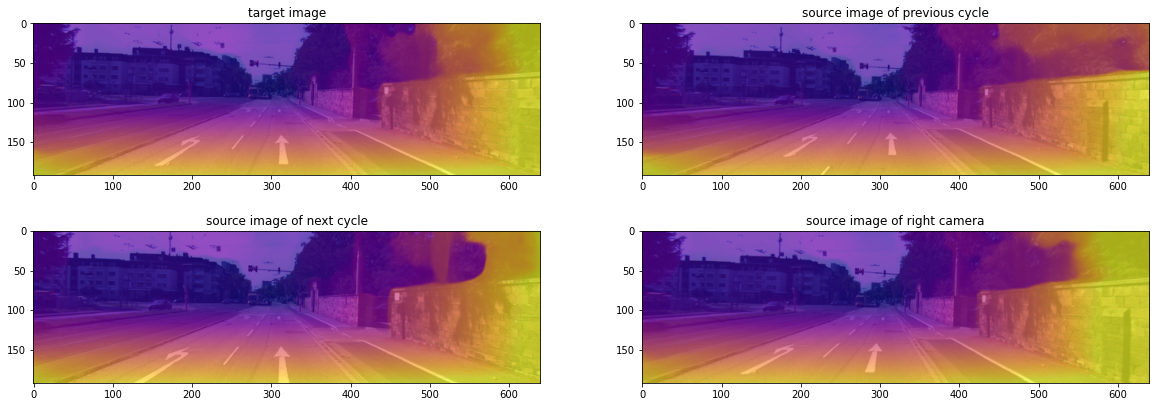

In [5]:
def depth_inference(images):
    with torch.no_grad():
        depth_features = depth_encoder(torch.cat(images, 0))
        outputs = depth_decoder(depth_features)
        return outputs[("disp", 0)]

def pose_inference(images, invert=False):
    with torch.no_grad():
        pose_features = [pose_encoder(torch.cat(images, 1))]
        axisangle, translation = pose_decoder(pose_features)
        T = transformation_from_parameters(axisangle[:, 0], translation[:, 0], invert)
        return T

disp_target, disp_src_prev, disp_src_next, disp_src_right = depth_inference([img_target_torch, img_src_prev_torch, img_src_next_torch, img_src_right_torch])
src_prev_T_target = pose_inference([img_src_prev_torch, img_target_torch], True)
src_next_T_target = pose_inference([img_target_torch, img_src_next_torch], False)

disp_target_np = disp_target.squeeze().cpu().numpy()
vmax = np.percentile(disp_target_np, 95)

plt.figure(figsize=(20, 7))
plt.subplot(221)
plt.imshow(img_target_resized)
plt.imshow(disp_target_np, cmap='plasma', vmax=vmax, alpha=0.7)
plt.title('target image')
plt.subplot(222)
plt.imshow(img_src_prev_resized)
plt.imshow(disp_src_prev.squeeze().cpu().numpy(), cmap='plasma', vmax=vmax, alpha=0.7)
plt.title('source image of previous cycle')
plt.subplot(223)
plt.imshow(img_src_next_resized)
plt.imshow(disp_src_next.squeeze().cpu().numpy(), cmap='plasma', vmax=vmax, alpha=0.7)
plt.title('source image of next cycle')
plt.subplot(224)
plt.imshow(img_src_right_resized)
plt.imshow(disp_src_right.squeeze().cpu().numpy(), cmap='plasma', vmax=vmax, alpha=0.7)
plt.title('source image of right camera')

## Load kamera intrinsics

In [6]:
with open('assets/kitti/calib_cam_to_cam.txt', 'r') as f:
    calib_cam = yaml.load(f)
K = np.fromstring(calib_cam['P_rect_02'], dtype=np.float32, sep=' ').reshape(3, 4)
K[:, -1] = 0
K = np.concatenate([K, np.array([0, 0, 0, 1]).reshape(1, 4)], axis=0)
print(K)

# rescale intrinsic matrix based on the ratio between original size and feed size
K[0] *= feed_width/original_width
K[1] *= feed_height/original_height
K_inv = np.linalg.inv(K)

[[721.53771973   0.         609.55932617   0.        ]
 [  0.         721.53771973 172.85400391   0.        ]
 [  0.           0.           1.           0.        ]
 [  0.           0.           0.           1.        ]]


## Warp source images to target frame


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


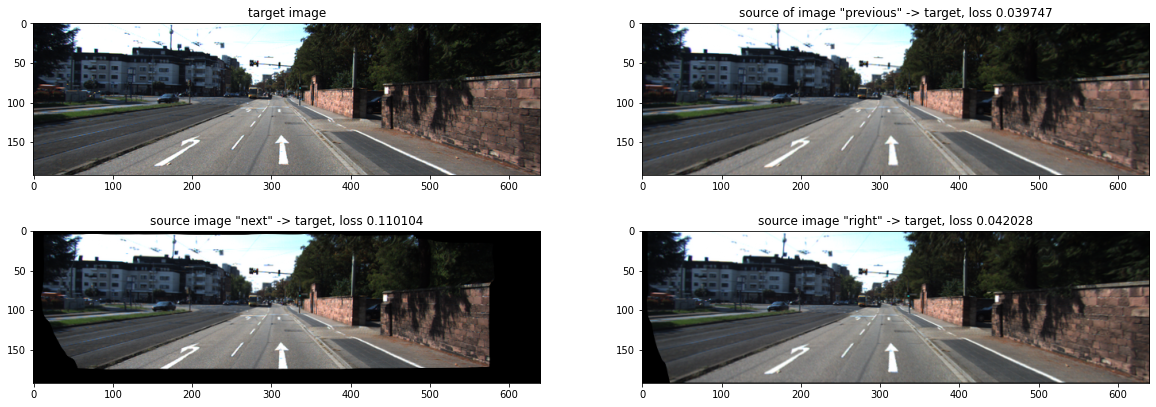

In [7]:
# convert disparity to depth
_, depth_target = disp_to_depth(disp_target, min_depth=0.1, max_depth=100)

backproject_depth = BackprojectDepth(1, feed_height, feed_width).cuda()
project_3d = Project3D(1, feed_height, feed_width).cuda()

# model was trained with a nomial baseline of 0.1 units
stereo_T = np.eye(4, dtype=np.float32)
stereo_T[0, 3] = -0.1

# back project the pixels of target image to 3D space
cam_points_target = backproject_depth(depth_target, torch.FloatTensor(K_inv[np.newaxis,:]).cuda())

# transform the 3d pixel coordinates from target frame to source frame and then project to 2d plane
pix_coords_src_prev = project_3d(cam_points_target, torch.FloatTensor(K[np.newaxis,:]).cuda(), src_prev_T_target)
pix_coords_src_next = project_3d(cam_points_target, torch.FloatTensor(K[np.newaxis,:]).cuda(), src_next_T_target)
pix_coords_src_right = project_3d(cam_points_target, torch.FloatTensor(K[np.newaxis,:]).cuda(), torch.from_numpy(stereo_T).cuda())

with torch.no_grad():
    img_src_prev_warped = F.grid_sample(img_src_prev_torch, pix_coords_src_prev, padding_mode="zeros")
    img_src_next_warped = F.grid_sample(img_src_next_torch, pix_coords_src_next, padding_mode="zeros")
    img_src_right_warped = F.grid_sample(img_src_right_torch, pix_coords_src_right, padding_mode="zeros")

plt.figure(figsize=(20, 7))
plt.subplot(221)
plt.title('target image')
plt.imshow(img_target_resized)
plt.subplot(222)
l1 = torch.abs(img_src_prev_warped-img_target_torch).mean()
plt.title('source of image "previous" -> target, loss %f'%l1)
plt.imshow(img_src_prev_warped.cpu().numpy()[0].transpose(1, 2, 0))
plt.subplot(223)
l1 = torch.abs(img_src_next_warped-img_target_torch).mean()
plt.title('source image "next" -> target, loss %f'%l1)
plt.imshow(img_src_next_warped.cpu().numpy()[0].transpose(1, 2, 0))
plt.subplot(224)
l1 = torch.abs(img_src_right_warped-img_target_torch).mean()
plt.title('source image "right" -> target, loss %f'%l1)
plt.imshow(img_src_right_warped.cpu().numpy()[0].transpose(1, 2, 0))

# Apply on video clips

In [8]:
def show_and_stream_result_video(input_video, output_path):
    # input reader
    cap = cv2.VideoCapture(input_video)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # init pose as original point
    prev = None
    prev_pose = np.eye(4)
    poses = [prev_pose[:,-1]]

    # write result video
    i = 0
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'XVID'), 10.0, (feed_width+320,feed_height*2))
    while True:
        success, img = cap.read()
        if not success:
            break
      
        # load video frame
        img = pil.fromarray(img[...,::-1])
        img = img.resize((feed_width, feed_height), pil.LANCZOS)
        img_torch = transforms.ToTensor()(img).unsqueeze(0).cuda()    

        # infer depth
        disp_np = depth_inference([img_torch]).squeeze().cpu().numpy()

        # infer pose transform
        if prev is not None:
            pose = pose_inference([prev, img_torch], True).cpu().numpy()
            prev_pose = prev_pose.dot(pose[0])
            poses += [prev_pose[:, -1]]

        # combine rgb image, depth map and VO plot
        combined = np.zeros((feed_height*2, feed_width+320, 3), dtype=np.uint8)
        combined[:feed_height,:feed_width] = np.array(img)
        combined[feed_height:,:feed_width] = plot_disp(disp_np, np.percentile(disp_np, 95))
        combined[:,-320:] = plot_vo_traj(poses, (5, 6))

        # write combined frame into new video
        out.write(combined[:,:,::-1])

        # display current combined image
        combined = pil.fromarray(combined)
        clear_output(wait=True)
        display(combined)

        i += 1
        print('\r', i+1, total_frames, end=' '*10)
        prev = img_torch

    out.release()

## KITTI dataset, on which the model was pre-trained
Note: please download the created video to watch the smooth result video

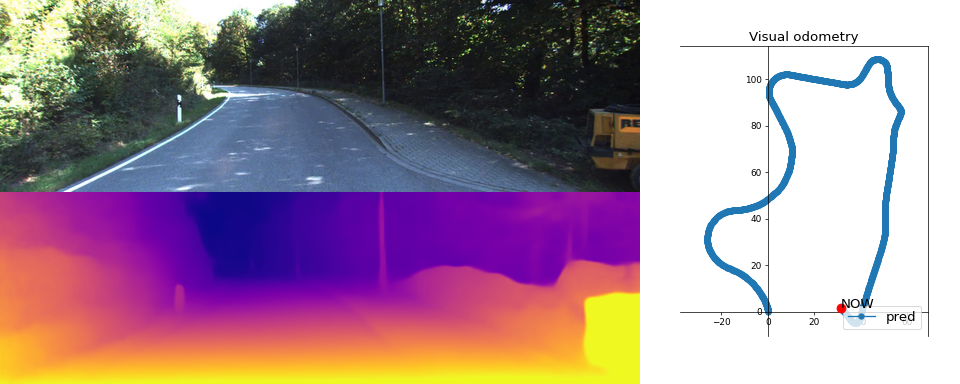

 1592 1591          

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
show_and_stream_result_video("assets/kitti_odom_09.mp4", "kitti_odom_09_result.avi")
files.download('kitti_odom_09_result.avi') 

## Cityscapes dataset which the pre-trained model has never seen before

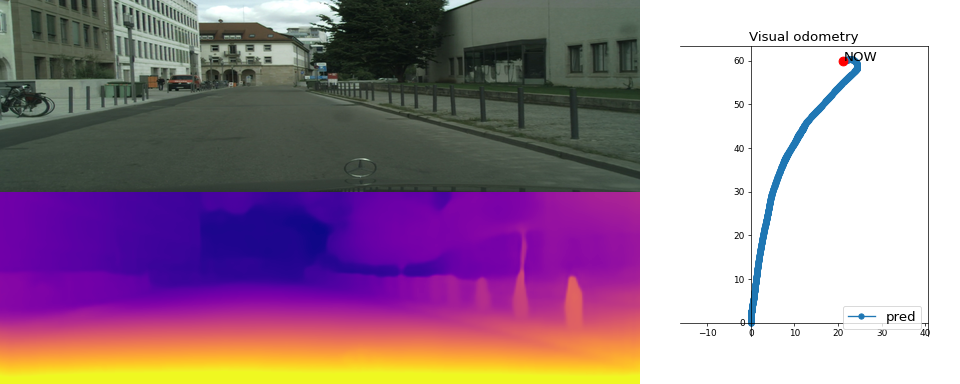

 1151 1150          

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
def select(seq):
    show_and_stream_result_video("assets/stuttgart_{}.mp4".format(seq), "stuttgart_{}_result.avi".format(seq))
    files.download('stuttgart_{}_result.avi'.format(seq))

## select one of the video clip
# select('00')
# select('01')
select('02')

# Reference

[1] Godard, C., Aodha, O. Mac, Firman, M., & Brostow, G. (2019). Digging into self-supervised monocular depth estimation. Proceedings of the IEEE International Conference on Computer Vision, 2019-Octob(1), 3827–3837. https://doi.org/10.1109/ICCV.2019.00393

[2] kwea123. monodepth2 example. https://gist.github.com/kwea123/3fa35aac268309fc1ccfbe78bb439a28

[3] Tinghui Zhou, Matthew Brown, Noah Snavely, D. L. (2017). Unsupervised learning of depth and ego-motion from video. CVPR, 58–65. https://doi.org/10.1109/AIVR46125.2019.00018

[4] KITTI vision benchmark suite: http://www.cvlibs.net/datasets/kitti/eval_odometry.php

[5] Cityscapes dataset: https://www.cityscapes-dataset.com/